## Import Libraries

In [82]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import holidays
from sklearn.metrics import mean_absolute_error
from joblib import dump
from typing import Optional,Dict,Tuple
import json
from geopy.geocoders import Nominatim
import xgboost
from sklearn.preprocessing import StandardScaler
plt.style.use("ggplot")
pd.set_option('display.max_columns', 500)

## Read Train Data

In [2]:
train=pd.read_csv('./train.csv')
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


In [4]:
train['datetime']=pd.to_datetime(train['datetime'])

In [5]:
train.isna().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [6]:
train = train.dropna(how='any')
train.shape[0]

2017824

In [7]:
train.duplicated().sum()

0

In [8]:
train['is_consumption'].value_counts()

is_consumption
0    1008912
1    1008912
Name: count, dtype: int64

In [9]:
train['county'].value_counts()

county
0     212872
11    197948
7     173042
5     151592
15    148714
4     147226
10    134604
14    125776
3     122464
9     122464
13    121024
2     115170
1      91848
8      91848
6      30616
12     30616
Name: count, dtype: int64

In [10]:
train['county'].unique().sum()

120

In [11]:
train['is_business'].value_counts()

is_business
1    1083222
0     934602
Name: count, dtype: int64

In [12]:
train['product_type'].value_counts()

product_type
3    918480
1    781428
0    170500
2    147416
Name: count, dtype: int64

## Analyse and Preprocess train data

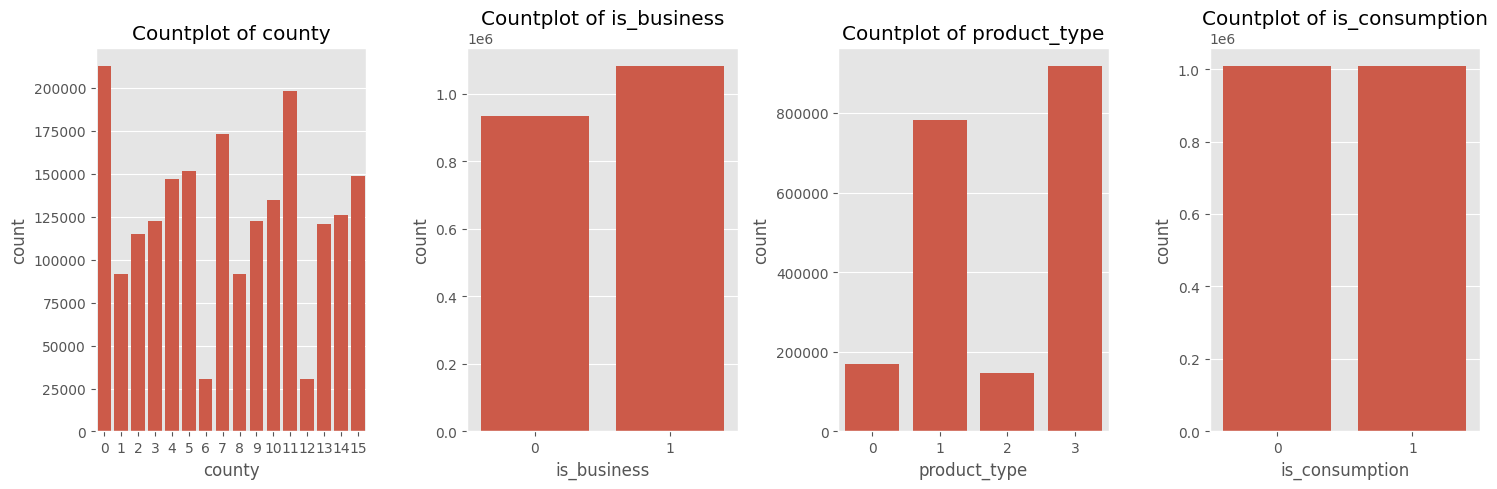

In [13]:
desc_columns = ['county', 'is_business', 'product_type', 'is_consumption']
num_cols = len(desc_columns)
fig, axs = plt.subplots(1, num_cols, figsize=(15, 5)) 
for i, column in enumerate(desc_columns):
    sns.countplot(data=train, x=column, ax=axs[i])
    axs[i].set_title(f'Countplot of {column}') 
plt.tight_layout()
plt.show()

In [14]:
train_avgd = (
    train
    .groupby(['datetime','is_consumption'])
    ['target'].mean()
    .unstack()
    .rename({0: 'produced', 1:'consumed'}, axis=1)
)
train_avgd

is_consumption,produced,consumed
datetime,,
2021-09-01 00:00:00,0.071508,325.570623
2021-09-01 01:00:00,0.194295,315.820951
2021-09-01 02:00:00,0.030246,315.752328
2021-09-01 03:00:00,0.024869,311.909574
2021-09-01 04:00:00,0.040852,317.493836
...,...,...
2023-05-31 19:00:00,174.322908,431.672446
2023-05-31 20:00:00,64.831000,474.340077
2023-05-31 21:00:00,13.178462,501.559800


In [15]:
train_avgd.mean()

is_consumption
produced     88.512348
consumed    460.275084
dtype: float64

The data clearly indicates a substantial disparity between energy consumption and energy production, with consumption levels notably surpassing the produced energy

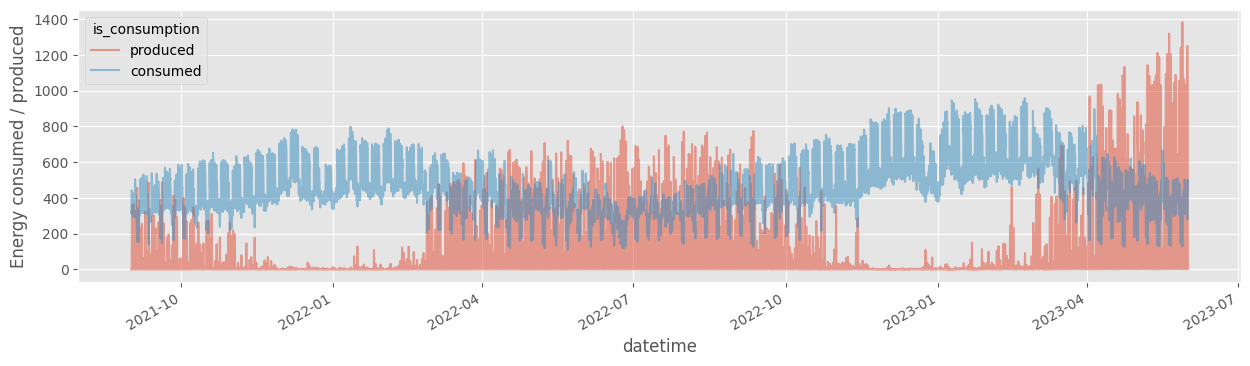

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
_ = train_avgd.plot(ax=ax, alpha=0.5)
_ = ax.set_ylabel('Energy consumed / produced')

Here are the montly averages for the same series
-The consumptions peaks in either January or February and is the least in the summer months
-The reverse is true for the production series

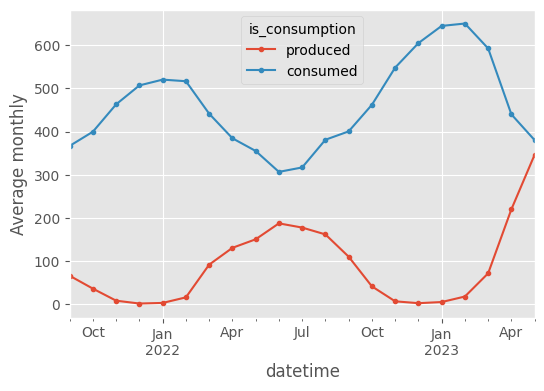

In [17]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
_ = train_avgd.resample('M').mean().plot(ax=ax, marker='.')
_ = ax.set_ylabel('Average monthly')

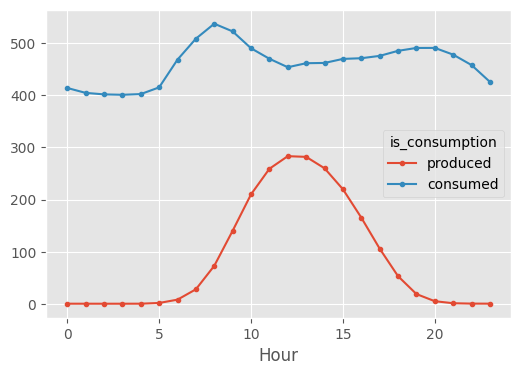

In [18]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
train_avgd.groupby(train_avgd.index.hour).mean().plot(ax=ax, marker='.')
_ = ax.set_xlabel('Hour')


The average energy consumption maintains a steady pattern throughout the day, experiencing a minor peak in the morning. In contrast, energy production reaches its zenith around midday before gradually declining toward the evening.

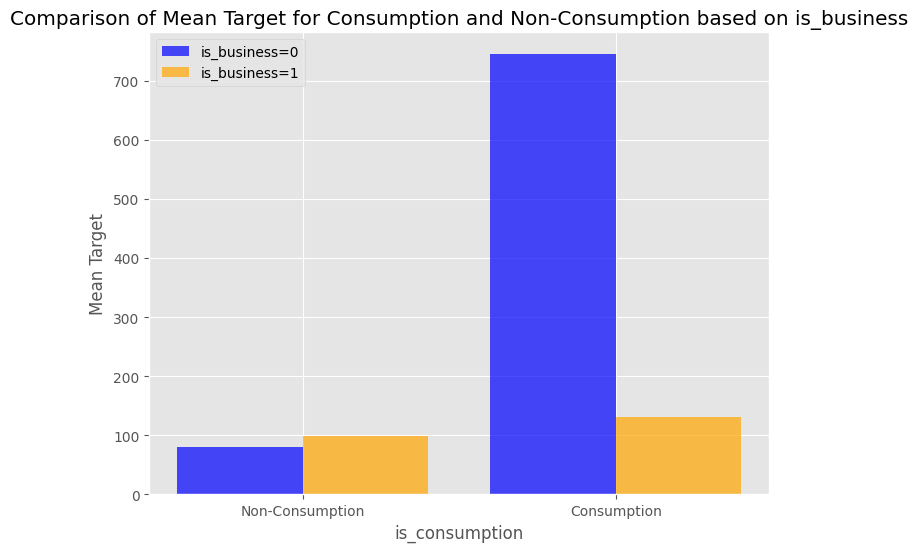

In [19]:
target_Business = train.loc[train["is_business"] == 1, ['target', 'is_consumption']]
target_nonBusiness=train.loc[train["is_business"] == 0, ['target', 'is_consumption']]
target_mean_0 = target_Business.groupby('is_consumption')['target'].mean()
target_mean_1 = target_nonBusiness.groupby('is_consumption')['target'].mean()
plt.figure(figsize=(8, 6))
plt.bar([0, 1], target_mean_0, color='blue', alpha=0.7, label='is_business=0', width=0.4)
plt.bar([x + 0.4 for x in range(2)], target_mean_1, color='orange', alpha=0.7, label='is_business=1', width=0.4)
plt.xlabel('is_consumption')
plt.ylabel('Mean Target')
plt.title('Comparison of Mean Target for Consumption and Non-Consumption based on is_business')
plt.xticks([0.2, 1.2], ['Non-Consumption', 'Consumption'])
plt.legend()
plt.show()

Observing the data, it's evident that non-business individuals consume significantly more energy compared to their business counterparts. Additionally, for business individuals, the energy production and consumption levels appear quite similar. However, within the non-business category, the energy consumption outweighs the energy production considerably.
This analysis highlights a distinctive discrepancy between the energy utilization patterns of business and non-business individuals. Non-business individuals exhibit higher energy consumption rates, with consumption surpassing their energy production, while the energy usage of business individuals remains relatively balanced.

In [20]:
target_consumed=train[train['is_consumption']==1]
target_produced=train[train['is_consumption']==0]

In [21]:
target_count_consumed = (
    target_consumed
    .groupby(['county'])
    ['target'].mean()
)
target_count_consumed.sort_values(ascending=False)

county
0     1626.459161
11     915.355235
12     547.225536
14     435.967583
5      380.041233
7      320.152238
10     307.162193
3      263.706926
4      250.338059
2      229.130839
15     186.290156
6      174.515958
13     140.865875
9      123.598537
8      121.164867
1       47.502497
Name: target, dtype: float64

In [22]:
target_count_produced = (
    target_produced
    .groupby(['county'])
    ['target'].mean()
)
target_count_produced.sort_values(ascending=False)

county
0     256.191883
11    128.201636
14     99.474381
7      90.077297
10     82.642888
5      82.047097
3      61.193426
13     57.935266
9      56.699870
8      55.553943
15     54.942529
4      44.979477
2      30.645256
1      28.765331
6       9.923319
12      6.495025
Name: target, dtype: float64

Upon analyzing the average energy consumption and production data for each county, it becomes evident that County 0 stands out as the county that both consumes and produces energy at the highest levels simultaneously.

In [23]:
target_productype_consumed = (
    target_consumed
    .groupby(['product_type'])
    ['target'].mean()
)
target_productype_consumed.sort_values(ascending=False)

product_type
3    809.279374
0    438.755381
1    136.351775
2     33.673468
Name: target, dtype: float64

In [24]:
target_productype_produced = (
    target_produced
    .groupby(['product_type'])
    ['target'].mean()
)
target_productype_produced.sort_values(ascending=False)

product_type
3    152.741970
1     41.115457
0     37.289363
2      5.531463
Name: target, dtype: float64

The dataset reveals that Product Type 3 stands out as the most utilized product, exhibiting both the highest production and consumption of energy

In [25]:
earliest_time = train['datetime'].min()
def extract_dt_attributes(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['date'] = df['datetime'].dt.date
    df['time'] = df['datetime'].dt.strftime('%H:%M:%S')
    df['year'] = df['datetime'].dt.year
    df['datediff_in_days'] = (
        df['datetime']- earliest_time
    ).dt.days
    time_features = {
        'hour': [0, 23],
        'dayofweek': [0, 6],
        'week': [1, 52],
        'month': [1, 12]
    }
    for col in time_features:
        if col=='week':
            df[col] = df['datetime'].dt.isocalendar().week.astype(np.int32)
        else:
            df[col] = getattr(df['datetime'].dt,col)
        col_min,col_max = time_features[col]
        angles = 2*np.pi*(df[col]-col_min)/(col_max-col_min+1)
        df[col+'_sine'] = np.sin(angles).astype('float')
        df[col+'_cosine'] = np.cos(angles).astype('float')
    return df

In [26]:
earliest_time

Timestamp('2021-09-01 00:00:00')

In [27]:
train_1=extract_dt_attributes(train).copy()

C:\Users\HP\AppData\Local\Temp\ipykernel_9008\3980148849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime'])
C:\Users\HP\AppData\Local\Temp\ipykernel_9008\3980148849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date
C:\Users\HP\AppData\Local\Temp\ipykernel_9008\3980148849.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [28]:
%%time
shift = 2
train_1['data_block_id_shifted'] = train_1['data_block_id'] + shift

train_1 = pd.merge(
    train_1,
    (
        train_1[[
            'county', 'is_business','is_consumption','product_type',
            'data_block_id_shifted', 'time', 'target']]
        .rename(columns={
            'data_block_id_shifted':'data_block_id', 
            'target':f'target_{shift}days_ago'
        })
    ),
    on = ['county', 'is_business','is_consumption','product_type', 'data_block_id', 'time'],
    how='left'
)
del train_1['data_block_id_shifted']

train_1.head(2)

CPU times: total: 2.36 s
Wall time: 2.98 s


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,datediff_in_days,hour,hour_sine,hour_cosine,dayofweek,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN


In [29]:
(
    train_1[['is_consumption', 'target', 'target_2days_ago']]
    .groupby('is_consumption')
    .corr()
    .round(3)
)

target  target_2days_ago
is_consumption                                           
0              target             1.000             0.822
               target_2days_ago   0.822             1.000
1              target             1.000             0.946
               target_2days_ago   0.946             1.000

In [30]:
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,datediff_in_days,hour,hour_sine,hour_cosine,dayofweek,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,0,0,0.000000,1.000000,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,0,0,0.000000,1.000000,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,00:00:00,2021,0,0,0.000000,1.000000,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,00:00:00,2021,0,0,0.000000,1.000000,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,00:00:00,2021,0,0,0.000000,1.000000,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,23:00:00,2023,637,23,-0.258819,0.965926,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,23:00:00,2023,637,23,-0.258819,0.965926,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,23:00:00,2023,637,23,-0.258819,0.965926,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,23:00:00,2023,637,23,-0.258819,0.965926,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5


## Read Electricity Prices Data

In [31]:
electricity_prices = pd.read_csv('./electricity_prices.csv')
electricity_prices.head(10)

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1
5,2021-09-01 05:00:00,93.58,2021-08-31 05:00:00,1
6,2021-09-01 06:00:00,118.70,2021-08-31 06:00:00,1
7,2021-09-01 07:00:00,135.44,2021-08-31 07:00:00,1
8,2021-09-01 08:00:00,140.72,2021-08-31 08:00:00,1
9,2021-09-01 09:00:00,130.00,2021-08-31 09:00:00,1


In [32]:
electricity_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB


## Analyse and Preprocess electricty prices data

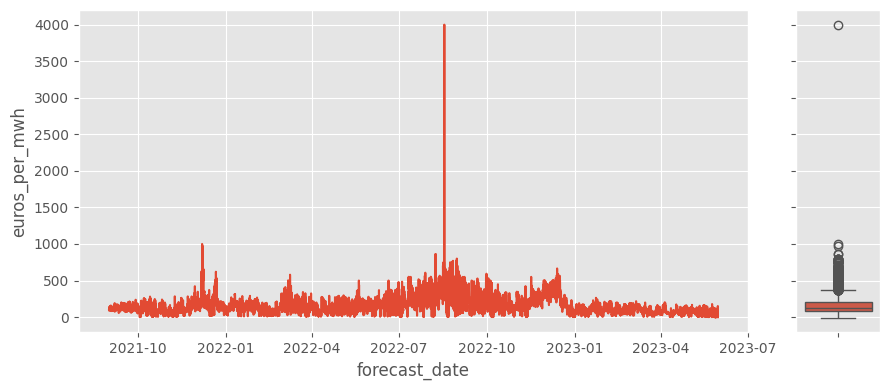

In [33]:
electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
electricity_prices['time'] = electricity_prices['forecast_date'].dt.strftime('%H:%M:%S')
fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(electricity_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(electricity_prices, y='euros_per_mwh', ax=axs[1])
fig.tight_layout()

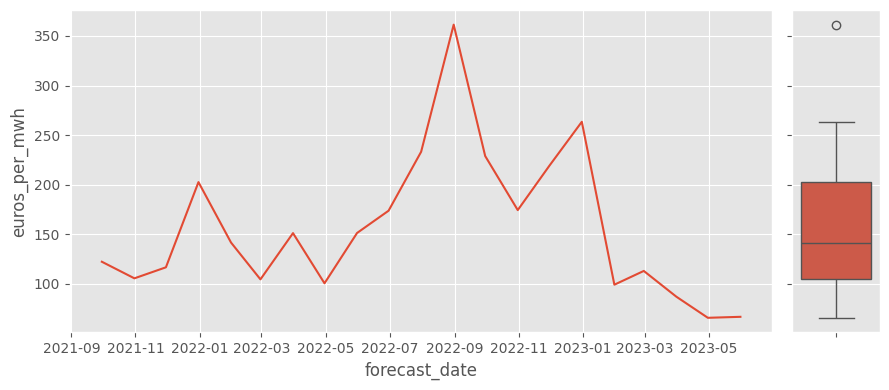

In [34]:
daily_elec_prices = (
    electricity_prices[['forecast_date', 'euros_per_mwh']]
    .set_index('forecast_date')
    .resample('M')
    .mean()
)
fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(daily_elec_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(daily_elec_prices, y='euros_per_mwh', ax=axs[1])
fig.tight_layout()

Electricity prices peak during the summer months, gradually declining from September onwards

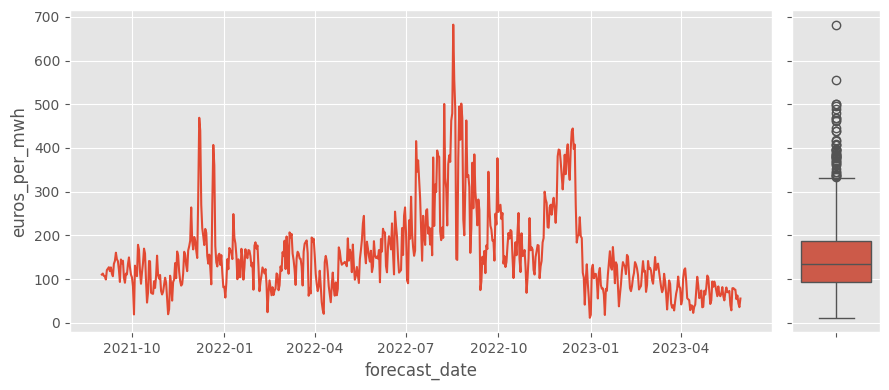

In [35]:
daily_elec_prices = (
    electricity_prices[['forecast_date', 'euros_per_mwh']]
    .set_index('forecast_date')
    .resample('D')
    .mean()
)
fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(daily_elec_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(daily_elec_prices, y='euros_per_mwh', ax=axs[1])
fig.tight_layout()

In [36]:
train_1 = pd.merge(
    train_1,
    electricity_prices[['time', 'data_block_id', 'euros_per_mwh']],
    how = 'left',
    on = ['time', 'data_block_id'] 
)
train_1.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,datediff_in_days,hour,hour_sine,hour_cosine,dayofweek,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago,euros_per_mwh
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN


In [37]:
train = pd.merge(
    train,
    electricity_prices[['time', 'data_block_id', 'euros_per_mwh']],
    how = 'left',
    on = ['time', 'data_block_id'] 
)
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,datediff_in_days,hour,hour_sine,hour_cosine,dayofweek,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,euros_per_mwh
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN


## Read Gas Prices Data

In [38]:
gas_prices =  pd.read_csv('./gas_prices.csv')
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])
gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [39]:
gas_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   forecast_date          637 non-null    datetime64[ns]
 1   lowest_price_per_mwh   637 non-null    float64       
 2   highest_price_per_mwh  637 non-null    float64       
 3   origin_date            637 non-null    object        
 4   data_block_id          637 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 25.0+ KB


## Analyse and Preprocess Gas Prices Data

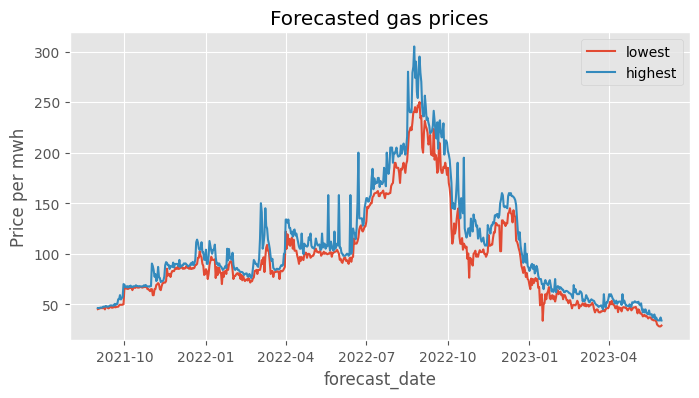

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
_ = sns.lineplot(gas_prices, x='forecast_date', y='lowest_price_per_mwh', ax=ax, label='lowest')
_ = sns.lineplot(gas_prices, x='forecast_date', y='highest_price_per_mwh', ax=ax, label='highest')
_ = ax.legend()
_ = ax.set_ylabel('Price per mwh')
_ = ax.set_title('Forecasted gas prices')

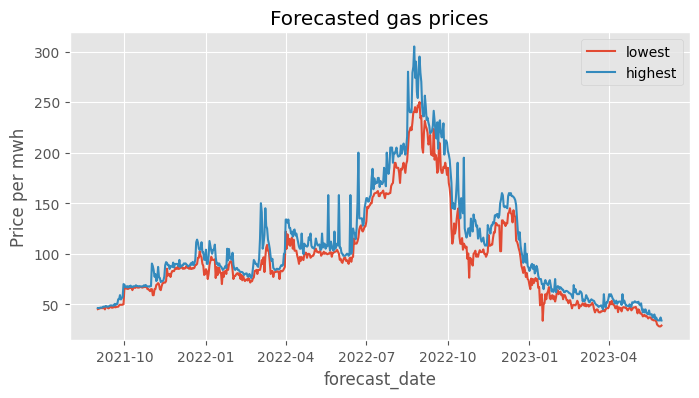

In [41]:
daily_gas_prices = (
    gas_prices[['forecast_date', 'lowest_price_per_mwh','highest_price_per_mwh']]
    .set_index('forecast_date')
    .resample('D')
    .mean()
)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
_ = sns.lineplot(daily_gas_prices, x='forecast_date', y='lowest_price_per_mwh', ax=ax, label='lowest')
_ = sns.lineplot(daily_gas_prices, x='forecast_date', y='highest_price_per_mwh', ax=ax, label='highest')
_ = ax.legend()
_ = ax.set_ylabel('Price per mwh')
_ = ax.set_title('Forecasted gas prices')

In [42]:
train_1 = pd.merge(
    train_1,
    gas_prices[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']],
    how = 'left',
    on = ['data_block_id'] 
)
train_1.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,datediff_in_days,hour,hour_sine,hour_cosine,dayofweek,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN


In [43]:
train = pd.merge(
    train,
    gas_prices[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']],
    how = 'left',
    on = ['data_block_id'] 
)
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,datediff_in_days,hour,hour_sine,hour_cosine,dayofweek,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,00:00:00,2021,0,0,0.0,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN


## Read Client Data

In [44]:
client = pd.read_csv('client.csv')
client.head(10)

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2
5,3,0,265,13417.79,1,2021-09-01,2
6,1,1,7,80.00,0,2021-09-01,2
7,3,1,42,472.60,0,2021-09-01,2
8,3,1,12,295.50,1,2021-09-01,2
9,3,2,33,414.50,0,2021-09-01,2


In [45]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_type        41919 non-null  int64  
 1   county              41919 non-null  int64  
 2   eic_count           41919 non-null  int64  
 3   installed_capacity  41919 non-null  float64
 4   is_business         41919 non-null  int64  
 5   date                41919 non-null  object 
 6   data_block_id       41919 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.2+ MB


In [46]:
client['date']=pd.to_datetime(client['date'])

## Analyse and Preporocess the Client Data

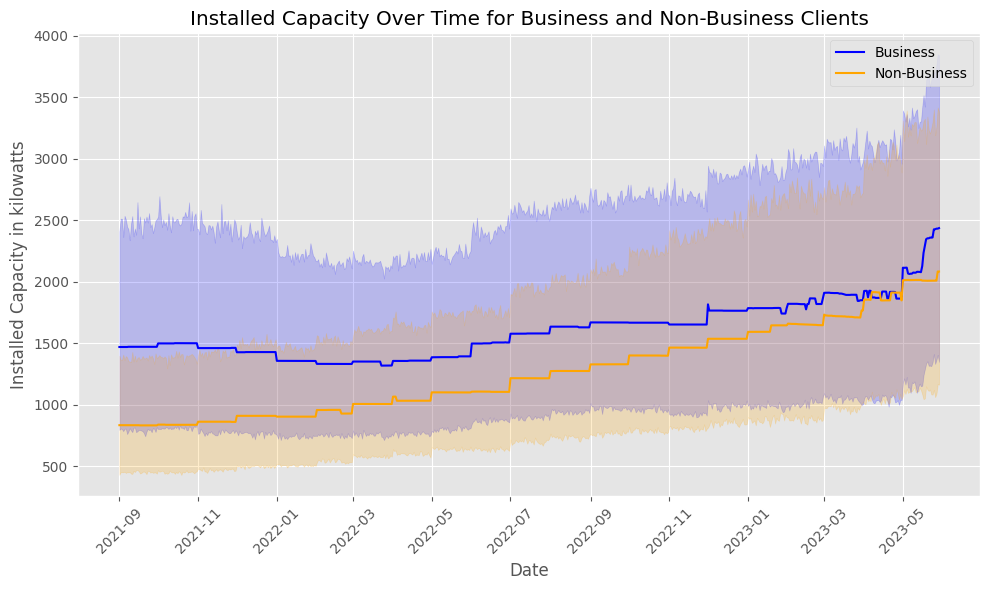

In [47]:
client_business = client[client['is_business'] == 1]
client_nonbusiness = client[client['is_business'] == 0]
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=client_business, x='date', y='installed_capacity', ax=ax, label='Business', color='blue')
sns.lineplot(data=client_nonbusiness, x='date', y='installed_capacity', ax=ax, label='Non-Business', color='orange')
ax.set_ylabel('Installed Capacity in kilowatts')
ax.set_xlabel('Date')
ax.set_title('Installed Capacity Over Time for Business and Non-Business Clients')
plt.xticks(rotation=45)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

installed_capacity - Installed photovoltaic solar panel capacity in kilowatts.
The installed photovoltaic (PV) solar panel capacity in kilowatts (kW) refers to the total power generating capacity of solar panels that have been installed and are operational at a specific location or within a specific region. It represents the maximum amount of electricity that these solar panels can generate under ideal conditions.
Over the years, there has been a gradual increase in the maximum amount of energy generated by solar panels. Notably, the output from business entities has surpassed that of non-business individuals.


## Country Id To Name Map

After preprocessing the county_id_to_name alongside the forecast_weather data to acquire the latitude and longitude of each station, the resulting dataset is known as county_lon_lats. This data processing task was completed by FABIENDANIEL on Kaggle  

In [48]:
location = pd.read_csv("./county_lon_lats.csv").drop(columns = ["Unnamed: 0"])
for k in ['latitude', 'longitude'] :
    location[k] = (10*location[k]).astype(int)
print(location.shape)
location.sample(5, random_state=1)

(75, 3)


,county,longitude,latitude
19,2,277,594
55,10,222,582
10,1,217,588
70,15,267,576
54,10,217,582


Each county can have multiple weather stations. Note that there is no data for county 12, which is marked as "UNKNOWN" in the county_id_to_name_map.json file. We will therefore create aggregate features for the weather attributes

<Axes: ylabel='county'>

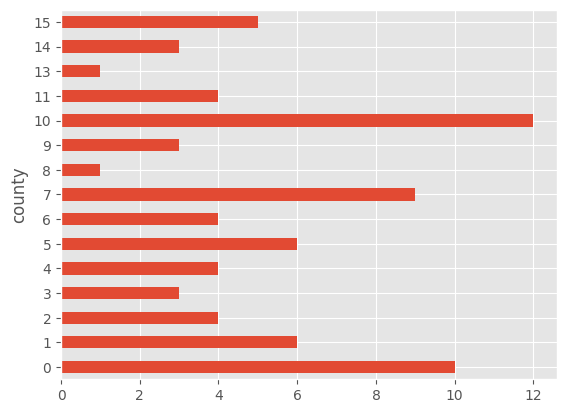

In [49]:
location.county.value_counts().sort_index().plot(kind='barh')

## Read and Preprocess The Forecast Weather Data

In [50]:
forecast_weather=pd.read_csv('forecast_weather.csv')
forecast_weather

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 00:00:00+00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 00:00:00+00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 00:00:00+00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 00:00:00+00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0


In [51]:
forecast_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall          

In [52]:
forecast_weather.duplicated().sum()

0

In [53]:
forecast_weather.isnull().sum()

latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
data_block_id                        0
forecast_datetime                    0
direct_solar_radiation               0
surface_solar_radiation_downwards    2
snowfall                             0
total_precipitation                  0
dtype: int64

In [54]:
forecast_weather['surface_solar_radiation_downwards']=forecast_weather['surface_solar_radiation_downwards'].ffill()

In [55]:
def process_weather_info(weather:pd.DataFrame, location=location) :
    weather = weather.drop_duplicates().reset_index(drop=True)
    for k in ['latitude', 'longitude'] :
        weather[k] = (10*weather[k]).astype(int)
    weather = pd.merge(weather, location, how='left', on=['latitude', 'longitude'])
    weather['county'] = weather['county'].fillna(-1).astype(int)
    return weather

In [56]:
forecast_weather = process_weather_info(forecast_weather)
print(forecast_weather.shape)
forecast_weather.head(5)

(3424512, 19)


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,county
0,576,217,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,-1
1,576,222,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,-1
2,576,227,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,-1
3,576,232,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,10
4,576,237,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,-1


In [57]:
dict_agg = {
    'temperature': ['min', 'mean', 'max'],
    'dewpoint': ['min', 'mean', 'max'],
    'direct_solar_radiation': ['min', 'mean', 'max'],
    'surface_solar_radiation_downwards': ['min', 'mean', 'max'],
    'cloudcover_total':['min','mean','max'],
    'snowfall':['min','mean','max']
}
keys = ['county', 'forecast_datetime']
forecast_weather = forecast_weather.groupby(keys).agg(dict_agg).reset_index()
forecast_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in forecast_weather.columns]
forecast_weather.columns = [x + '_f' if x not in keys else x for x in forecast_weather.columns]
print(forecast_weather.shape)
forecast_weather.head(2)

(244992, 20)


,county,forecast_datetime,temperature_min_f,temperature_mean_f,temperature_max_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f
0,-1,2021-09-01 01:00:00+00:00,9.783228,13.162114,16.003564,8.423364,11.012977,12.878687,0.0,0.0,0.0,0.0,0.0,0.0,0.044754,0.446748,1.000000,0.0,0.0,0.0
1,-1,2021-09-01 02:00:00+00:00,9.828760,13.108703,15.790552,8.596460,10.802036,12.211328,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.427797,0.993347,0.0,0.0,0.0


In [58]:
forecast_weather['forecast_datetime'] = (
    pd.to_datetime(forecast_weather['forecast_datetime'])
    .dt.tz_localize(None)
)

train_1 = pd.merge(
    train_1, 
    forecast_weather.rename(columns = {'forecast_datetime': 'datetime'}),
    how = 'left',
    on = ['county', 'datetime']
)
train = pd.merge(
    train, 
    forecast_weather.rename(columns = {'forecast_datetime': 'datetime'}),
    how = 'left',
    on = ['county', 'datetime']
)

In [59]:
print(train_1.shape)
print(train.shape)

(2017824, 47)
(2017824, 46)


In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 46 columns):
 #   Column                                    Dtype         
---  ------                                    -----         
 0   county                                    int64         
 1   is_business                               int64         
 2   product_type                              int64         
 3   target                                    float64       
 4   is_consumption                            int64         
 5   datetime                                  datetime64[ns]
 6   data_block_id                             int64         
 7   row_id                                    int64         
 8   prediction_unit_id                        int64         
 9   date                                      object        
 10  time                                      object        
 11  year                                      int32         
 12  datediff_in_da

In [61]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 47 columns):
 #   Column                                    Dtype         
---  ------                                    -----         
 0   county                                    int64         
 1   is_business                               int64         
 2   product_type                              int64         
 3   target                                    float64       
 4   is_consumption                            int64         
 5   datetime                                  datetime64[ns]
 6   data_block_id                             int64         
 7   row_id                                    int64         
 8   prediction_unit_id                        int64         
 9   date                                      object        
 10  time                                      object        
 11  year                                      int32         
 12  datediff_in_da

In [62]:
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,datediff_in_days,hour,hour_sine,hour_cosine,dayofweek,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,temperature_min_f,temperature_mean_f,temperature_max_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,0,0,0.000000,1.000000,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,0,0,0.000000,1.000000,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,00:00:00,2021,0,0,0.000000,1.000000,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,00:00:00,2021,0,0,0.000000,1.000000,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,00:00:00,2021,0,0,0.000000,1.000000,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017819,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,23:00:00,2023,637,23,-0.258819,0.965926,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,-1.29,29.0,34.0,9.068506,9.5448,10.520532,3.746973,4.782935,5.657861,0.0,0.0,0.0,0.0,0.0,0.0,0.555603,0.707452,0.914429,0.0,0.0,0.0
2017820,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,23:00:00,2023,637,23,-0.258819,0.965926,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,-1.29,29.0,34.0,9.068506,9.5448,10.520532,3.746973,4.782935,5.657861,0.0,0.0,0.0,0.0,0.0,0.0,0.555603,0.707452,0.914429,0.0,0.0,0.0
2017821,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,23:00:00,2023,637,23,-0.258819,0.965926,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,-1.29,29.0,34.0,9.068506,9.5448,10.520532,3.746973,4.782935,5.657861,0.0,0.0,0.0,0.0,0.0,0.0,0.555603,0.707452,0.914429,0.0,0.0,0.0
2017822,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,23:00:00,2023,637,23,-0.258819,0.965926,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,-1.29,29.0,34.0,9.068506,9.5448,10.520532,3.746973,4.782935,5.657861,0.0,0.0,0.0,0.0,0.0,0.0,0.555603,0.707452,0.914429,0.0,0.0,0.0


## Prepaer the Data

In [72]:
not_feature_columns = [
    'datetime', 
    'row_id',
    'prediction_unit_id',
    'date',
    'time'
]

In [73]:
X = train.drop(['target', 'data_block_id'] + not_feature_columns, axis=1)
y = train['target']

In [74]:
X_1 = train_1.drop(['target', 'data_block_id'] + not_feature_columns, axis=1)
y_1 = train_1['target']

In [86]:
float_columns = X_1.select_dtypes(include=['float']).columns.tolist()
scaler = StandardScaler()
X_1[float_columns] = scaler.fit_transform(X_1[float_columns])

In [ ]:
X_1.isnull().sum()

In [87]:
float_columns = X.select_dtypes(include=['float']).columns.tolist()
scaler_train = StandardScaler()
X[float_columns] = scaler_train.fit_transform(X[float_columns])

In [88]:
scaler_filename = 'scaler.pkl'
dump(scaler, scaler_filename)
scaler_filename = 'scaler_train.pkl'
dump(scaler, scaler_filename)

['scaler_train.pkl']

In [90]:
X.to_csv('train_prep.csv')
y.to_csv('target.csv')
X_1.to_csv('train_prep1.csv')
y_1.to_csv('target_1.csv')

In [91]:
X_1.isnull().sum()

county                                          0
is_business                                     0
product_type                                    0
is_consumption                                  0
year                                            0
datediff_in_days                                0
hour                                            0
hour_sine                                       0
hour_cosine                                     0
dayofweek                                       0
dayofweek_sine                                  0
dayofweek_cosine                                0
week                                            0
week_sine                                       0
week_cosine                                     0
month                                           0
month_sine                                      0
month_cosine                                    0
target_2days_ago                             9168
euros_per_mwh                                3196


In [81]:
def get_final_df(df, revealed_targets, client, forecast_weather, electricity_prices, gas_prices):
    
    # get datetime features
    extract_dt_attributes(df)
    
    ### Target 2 days ago #### 
    revealed_targets = revealed_targets.rename(columns={'target':'target_2days_ago'})
    revealed_targets['datetime'] = pd.to_datetime(revealed_targets['datetime']) + pd.Timedelta(days=2)
    df = pd.merge(
        df,
        revealed_targets[
            ['county', 'is_business','is_consumption','product_type', 'datetime', 'target_2days_ago']
        ],
        how='left',
        on=['county', 'is_business','is_consumption','product_type', 'datetime']
    )
    
    ### Electricity prices ####
    electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
    electricity_prices['time'] = electricity_prices['forecast_date'].dt.strftime('%H:%M:%S')
    electricity_prices['date'] = (electricity_prices['forecast_date'] + pd.Timedelta(days=1)).dt.date

    df = pd.merge(
        df, electricity_prices[['time', 'date', 'euros_per_mwh']],
        how = 'left',
        on = ['time', 'date'] 
    )
    
    ### Gas prices ###
    
    gas_prices['date'] = (pd.to_datetime(gas_prices['forecast_date']) + pd.Timedelta(days=1)).dt.date

    df = pd.merge(
        df, gas_prices[['date', 'lowest_price_per_mwh', 'highest_price_per_mwh']],
        how = 'left',
        on = ['date'] 
    )
    
    ### Client information ###
    client['date'] = (client['date'] + pd.Timedelta(days=2)).dt.date
    
    df = pd.merge(
        df, client,
        how='left',
        on = ['date', 'product_type', 'county', 'is_business'],
    )
    
    ### Forecast weather ###
    forecast_weather = process_weather_info(forecast_weather)
    
    dict_agg = {
        'temperature': ['min', 'mean', 'max'],
        'dewpoint': ['min', 'mean', 'max'],
        'direct_solar_radiation': ['min', 'mean', 'max'],
        'surface_solar_radiation_downwards': ['min', 'mean', 'max']
    }

    keys = ['county', 'forecast_datetime']
    forecast_weather = forecast_weather.groupby(keys).agg(dict_agg).reset_index()

    # Flatten columns names
    forecast_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in forecast_weather.columns]
    forecast_weather.columns = [x + '_f' if x not in keys else x for x in forecast_weather.columns]
    
    forecast_weather['forecast_datetime'] = (
        pd.to_datetime(forecast_weather['forecast_datetime'])
        .dt.tz_localize(None)  # Remove timezone information
    )
    
    df = pd.merge(
        df, 
        forecast_weather.rename(columns = {'forecast_datetime': 'datetime'}),
        how = 'left',
        on = ['county', 'datetime']
    )
    return df

In [ ]:
import enefit
env = enefit.make_env()
iter_test = env.iter_test()

for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    
    test = test.rename(columns={'prediction_datetime':'datetime'})
    test = get_final_df(test, revealed_targets, client, forecast_weather, electricity_prices, gas_prices)
    
    X_test = test.drop(not_feature_columns, axis=1)
    float_columns = X_test.select_dtypes(include=['float']).columns.tolist()
    scaler = StandardScaler()
    X_test[float_columns] = scaler.fit_transform(X_test[float_columns])
    sample_prediction['target'] = model.predict(X_test)
    env.predict(sample_prediction)